In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model, Input

from python.simulation import Simulation
import pandas as pd
import os
import heapq
import numpy as np
import matplotlib.pyplot as plt

In [9]:
class DCEnv:
    def __init__(self):
        self.racks = 12
        self.chassis_per_rack = 10
        self.servers_per_chassi = 3

        self.servers = ["P02R{:02}C{:02}SRV{:02}".format(rack, chassi, srv) for rack in range(1, self.racks+1) for chassi in range(1, self.chassis_per_rack+1) for srv in range(1, self.servers_per_chassi+1)]
        self.sensors = ["sensors_racks_{:02}_to_{:02}_{}_{}".format(rack, rack + 2, direction, loc) for direction in ["in", "out"] for rack in [1, 4, 7, 10] for loc in ['b', 'm', 't']]

        self.seed = 37

        self.job_rate = 10
        self.job_power = 50
        self.job_duration = 5
        self.max_load = 10000 # Max kW per server
        self.rpm = 2000

        # Kinematic viscosity of air (m^2/s)
        self.nu = 1.568e-5
        # Thermal conductivity (kW/m K)
        self.k = 2.624e-5
        # Prandtl number of air
        self.Pr = 0.707

        # Chassi fan specs from PFR0812DHE fan datasheet
        # Max input power in W
        Pmax = 25.2
        # Max RPM
        Nmax = 11000.0
        # Operational speed (RPM)
        Nop = 8000.0
        # Max air flow in CFM
        Qmax = 109.7
        # Fans per server
        Nfans = 2
        # Operational power from cube law of fans
        Pop = Pmax / (Nmax / Nop)**3 * Nfans
        # Assume fan volumetric flow is proportional to power 
        # around operating point
        Qop = Qmax / (Pmax / Pop)
        # Calculate flow in m^3/s per RPM at
        self.Q_per_RPM = Qop * 0.3048**3 / 60 / Nop

    def calc_flow(self):
        # Max input power in W, 2 fans
        Pmax = 25.2 * 2 
        # Max RPM
        Nmax = 11000.0
        # Max air flow in CFM, 2 fans
        Qmax = 109.7 * 2 

        Tcpu = Tin + R*p/Q
        N = Nmin + (Nmax - Nmin) * Tcpu / Tdes
        Q = Qmax * N / Nmax
        P = Pmax * (N / Nmax)**3

    def reset(self):
        self.loads = [45 for _ in range(len(self.servers))]
        self.vol_flows = [self.rpm * self.Q_per_RPM for _ in range(0, len(self.servers))]
        self.event_queue = []
        
        self.n_jobs = 0

        self.rng = np.random.default_rng(self.seed)

        self.sim = Simulation(f'{os.getcwd()}/problems/ocp/project.lbm')
        self.start_time = self.sim.get_time()
        self.target_time = 0
        self.sim.set_time_averaging_period(5)

        self.sim.set_boundary_conditions(self.servers, [40 for _ in self.vol_flows], self.vol_flows)

        return {"time": self.get_time(), "temps":np.zeros(len(self.sensors)), "loads":np.copy(self.loads), "jobs":self.n_jobs}
    
    # Calculate the expected temperature jump across the servers (convert to kW)
    def deltaT(self, p, q):
        return (p / 1000 * self.nu) / (q * self.k * self.Pr)

    def queue_load(self, srv_idx, power, start, dur):
        heapq.heappush(self.event_queue, (start, srv_idx, power, dur))

    def get_time(self):
        return (self.sim.get_time() - self.start_time).total_seconds()

    def step(self, placements, dt=1):
        assert(len(placements) == self.n_jobs)

        self.target_time += dt

        for idx in placements:
            self.queue_load(idx, self.job_power, self.get_time(), self.job_duration)
        
        start_time = self.get_time()
        jobs_done = []
        while len(self.event_queue) > 0 and self.event_queue[0][0] <= self.target_time:
            t, srv_idx, power, dur = heapq.heappop(self.event_queue)
            if t > self.get_time():
                self.sim.run(t - self.get_time())
            if dur < 0: # This is a finished job
                self.loads[srv_idx] -= power
            elif self.loads[srv_idx] < self.max_load: # This is a job that is placed on a server
                self.loads[srv_idx] += power
                temp = self.deltaT(self.loads[srv_idx], self.vol_flows[srv_idx])
                #self.sim.set_boundary_conditions([self.servers[srv_idx]], [temp], [self.vol_flows[srv_idx]])
                heapq.heappush(self.event_queue, (self.get_time() + dur, srv_idx, power, -1))
            else: # Server is full, job is queued
                heapq.heappush(self.event_queue, (self.get_time() + 1, srv_idx, power, dur))
        if self.target_time > self.get_time():
            self.sim.run(self.target_time - self.get_time())

        self.n_jobs = self.rng.poisson(self.job_rate * (self.get_time() - start_time))
        temps = self.get_temps()
        state = {"time": self.get_time(), "temps":temps, "loads":np.copy(self.loads), "jobs":self.n_jobs}
        split_idx = len(self.sensors) // 2
        reward = -(np.var(temps[:split_idx]) + np.var(temps[split_idx:])) # Check variance of inlets and outlets seperately
        return state, reward

    def get_temps(self):
        df = self.sim.get_averages("temperature")[[*self.sensors]]
        return df.iloc[[-1]].to_numpy()[0]

    def show_hist(self, srv_idxs, start, stop):
        racks = [((idx // (self.chassis_per_rack * self.servers_per_chassi)) // self.racks) * self.racks + 1 for idx in srv_idxs] # Find lower index of rack in range for average
        sensor_names = ["sensors_racks_{:02}_to_{:02}_out_{}".format(rack, rack + 2, loc) for rack in racks for loc in ['b', 'm', 't']]
        df = self.sim.get_averages("temperature")[["time", *sensor_names]]
        df["time"] = (df.time - self.start_time).dt.total_seconds()
        return df.set_index('time').loc[start:stop]

dc = DCEnv()

In [10]:
def plot_all(hist):
    fig, axs = plt.subplots(2, 2, figsize=(25, 15))

    split_idx = len(dc.sensors) // 2
    ts = [h[0]["time"] for h in hist]

    axs[0, 0].plot(ts, [h[0]["temps"][:split_idx] for h in hist])
    axs[0, 0].set_ylabel("temperature [C]")
    axs[0, 0].set_xlabel("time [s]")
    axs[0, 0].legend(dc.sensors[:split_idx])

    axs[0, 1].plot(ts, [h[0]["temps"][split_idx:] for h in hist])
    axs[0, 1].set_ylabel("temperature [C]")
    axs[0, 1].set_xlabel("time [s]")
    axs[0, 1].legend(dc.sensors[split_idx:])

    axs[1, 0].plot(ts, [np.sum(h[0]["loads"].reshape(-1, dc.chassis_per_rack * dc.servers_per_chassi), axis=1) for h in hist])
    axs[1, 0].set_ylabel("load [W]")
    axs[1, 0].set_xlabel("time [s]")
    axs[1, 0].legend(["rack_{:02}".format(i+1) for i in range(dc.racks)])

    axs[1, 1].plot(ts, [h[2] for h in hist])
    axs[1, 1].set_ylabel("reward")
    axs[1, 1].set_xlabel("time [s]")

    plt.show()

In [11]:
def random_action(s):
    return np.random.randint(len(dc.servers), size=s["jobs"])

s = dc.reset()

hist = []
for _ in range(60):
    print("time {}: new jobs {} highest temp {}".format(s["time"], s["jobs"], max(s["temps"])))
    a = random_action(s)
    sp, r = dc.step(a)
    # Do stuff with s, a, r, sp 
    hist.append((s, a, r, sp))
    s = sp


time 0.0: new jobs 0 highest temp 0.0
time 1.000654: new jobs 12 highest temp 0.0
time 2.001308: new jobs 8 highest temp 0.0
time 3.001962: new jobs 22 highest temp 0.0
time 4.002616: new jobs 7 highest temp 0.0
time 5.00327: new jobs 7 highest temp 26.87967872619629
time 6.003924: new jobs 12 highest temp 26.87967872619629
time 7.004578: new jobs 8 highest temp 26.87967872619629
time 8.005232: new jobs 4 highest temp 26.87967872619629
time 9.005886: new jobs 10 highest temp 26.87967872619629
time 10.00654: new jobs 13 highest temp 28.33881378173828
time 11.007194: new jobs 8 highest temp 28.33881378173828
time 12.007848: new jobs 14 highest temp 28.33881378173828
time 13.008502: new jobs 9 highest temp 28.33881378173828
time 14.009156: new jobs 9 highest temp 28.33881378173828
time 15.00981: new jobs 8 highest temp 28.955955505371094
time 16.010464: new jobs 11 highest temp 28.955955505371094
time 17.011118: new jobs 10 highest temp 28.955955505371094
time 18.011772: new jobs 14 highe

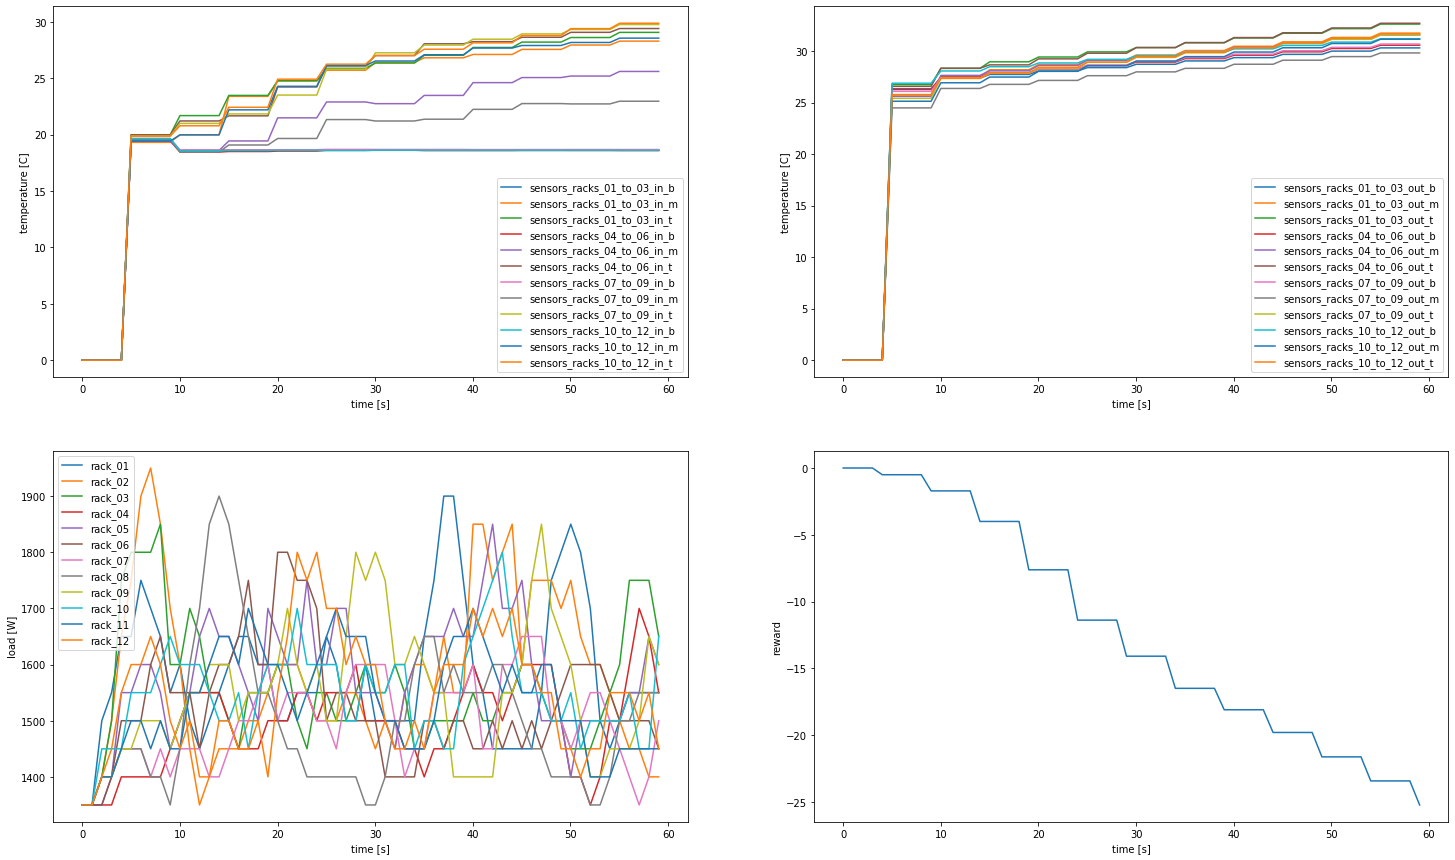

In [12]:
plot_all(hist)

In [ ]:
def fill_action(s):
    placements = []
    for srv in range(len(dc.servers)):
        if len(placements) == s["jobs"]:
            break
        if s["loads"][srv] < 10000:
            placements.append(srv)
    return placements

s = dc.reset()

hist = []
for _ in range(3600):
    print("time {}/{}: new jobs {} highest temp {}".format(dc.get_time(), dc.target_time, s["jobs"], max(s["temps"])))
    a = fill_action(s)
    sp, r = dc.step(a)
    # Do stuff with s, a, r, sp
    hist.append((s, a, r, sp))
    s = sp

In [ ]:
plot_all(hist)

In [ ]:
def rl_action(s):
    pass

s = dc.reset()

hist = []
for _ in range(3600):
    print("time {}/{}: new jobs {} highest temp {}".format(dc.get_time(), dc.target_time, s["jobs"], max(s["temps"])))
    a = rl_action(s)
    sp, r = dc.step(a)
    # Do stuff with s, a, r, sp
    hist.append((s, a, r, sp))
    s = sp

In [ ]:
hist = [h[1:] for h in hist]
plot_all(hist)